# Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

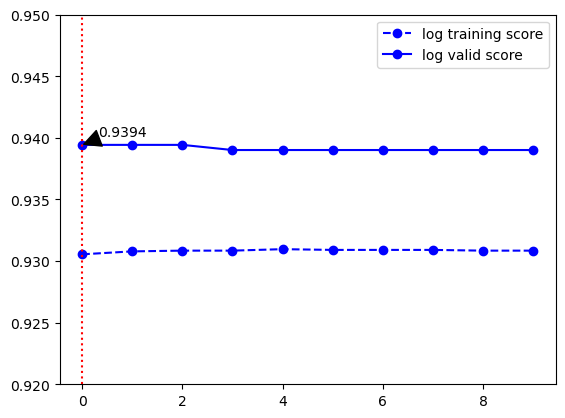

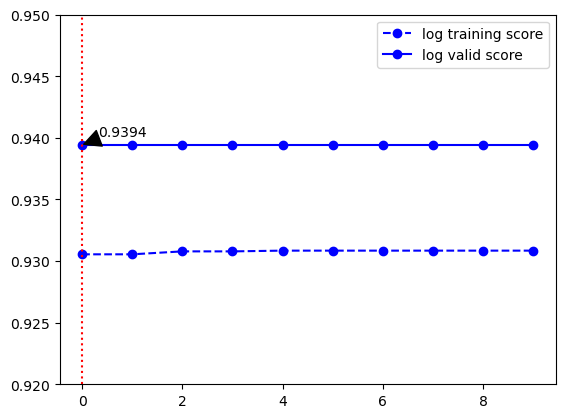

************************************************************
There are 6 set of X
X_train_selected_t1, X_train_selected_t2, X_valid_selected_t1,X_valid_selected_t2,X_test_selected_t1,X_test_selected_t2
------------------------------------------------------------
Normalized version
X_train_selected_t1_norm, X_train_selected_t2_norm, X_valid_selected_t1_norm,X_valid_selected_t2_norm,X_test_selected_t1_norm,X_test_selected_t2_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [2]:
%run Data_preprocessing_realmean_final.ipynb

In [35]:

X_train_norm = X_train_selected_t2_norm
X_valid_norm = X_valid_selected_t2_norm
X_test_norm = X_test_selected_t2_norm

print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)


(16760, 61)
(2394, 61)
(4790, 61)


# Neural Network Using Sklearn build in function

In [4]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(100,), 
                   activation='relu',
                   solver='adam', 
                   alpha=0.0001, 
                   batch_size='auto', 
                   learning_rate='constant', 
                   learning_rate_init=0.01, 
                   power_t=0.5, 
                   max_iter=200, 
                   shuffle=True, 
                   random_state=None, 
                   tol=0.0001, 
                   verbose=False, 
                   warm_start=False, 
                   momentum=0.9, 
                   nesterovs_momentum=True, 
                   early_stopping=True, 
                   validation_fraction=0.1, 
                   beta_1=0.9, 
                   beta_2=0.999, 
                   epsilon=1e-08, 
                   n_iter_no_change=10, 
                   max_fun=15000)

clf.fit(X_train_norm, y_train_t2_value)

clf.score(X_valid_norm, y_valid_t2_value)

0.10908917464224988

# Evaluation Matrix

In [37]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [6]:
y_pred = clf.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

1.8823784334484728

# Hyperparameter and setting tuning

## Layer Choices

100%|█████████████████████████████████████████| 156/156 [15:14<00:00,  5.86s/it]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), 

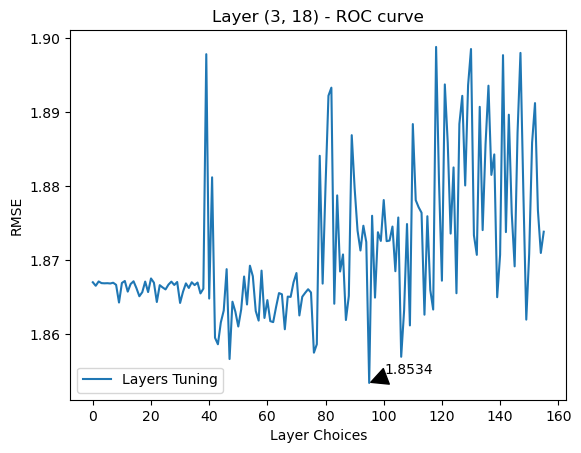

In [66]:
layer_list = []
rmse_lst=[]

for x in range (1,5,1):
    for y in range (1,40,1):
        layer_list.append((x,y))

for j in tqdm(range(len(layer_list))):
    i = layer_list[j]
    clf = MLPRegressor(solver="sgd",
                       alpha=1e-5,
                       hidden_layer_sizes=i,
                       activation='logistic',
                       learning_rate_init=0.1,
                       learning_rate="adaptive", 
                       random_state=2000,
                       max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(layer_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(layer_list))), rmse_lst, label='Layers Tuning')
plt.xlabel('Layer Choices')
plt.ylabel('RMSE')
plt.title(f"Layer {layer_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [67]:
best_layernumber = layer_list[index]
best_layernumber

(3, 18)

## Solver Choices

['lbfgs', 'sgd', 'adam']


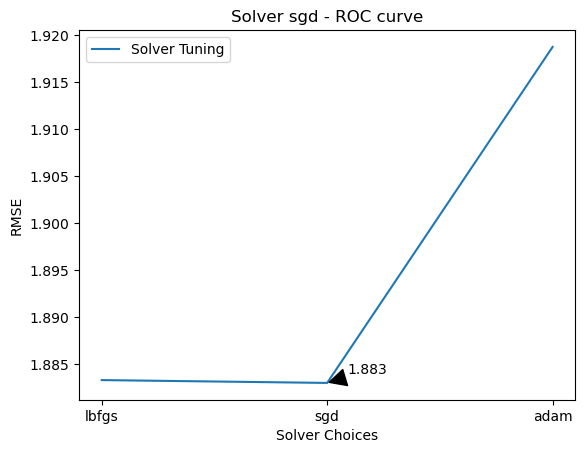

In [68]:
solver_list = ["lbfgs","sgd","adam"]
rmse_lst=[]

for i in solver_list:
    clf = MLPRegressor(solver=i,
                       alpha=1e-5,
                       hidden_layer_sizes=best_layernumber,
                       activation='identity',
                       learning_rate_init=0.1,
                       learning_rate="adaptive", 
                       random_state=3612,
                       max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(solver_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(solver_list, rmse_lst, label='Solver Tuning')
plt.xlabel('Solver Choices')
plt.ylabel('RMSE')
plt.title(f"Solver {solver_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [69]:
index = np.argmin(rmse_lst)
best_solver = solver_list[index]
best_solver

'sgd'

## Learning rate tuning

[0.001, 0.0032500000000000003, 0.0055000000000000005, 0.007750000000000001, 0.01, 0.01, 0.0325, 0.05500000000000001, 0.0775, 0.1, 0.1, 0.325, 0.55, 0.775, 1.0]


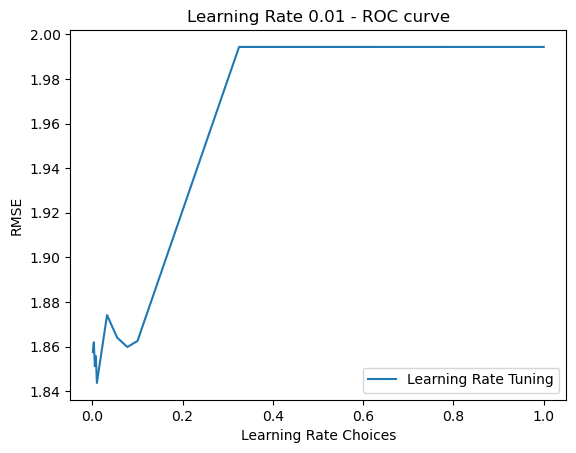

1.8437


In [70]:
lr_list = list(np.linspace(0.001,0.01,5))+list(np.linspace(0.01,0.1,5))+list(np.linspace(0.1,1,5))
rmse_lst=[]

for i in lr_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=i,
                        learning_rate="adaptive", 
                        alpha=1e-5,
                        random_state=3612,
                        activation="relu",
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(lr_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(lr_list, rmse_lst, label='Learning Rate Tuning')
plt.xlabel('Learning Rate Choices')
plt.ylabel('RMSE')
plt.title(f"Learning Rate {lr_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()
print(np.min(rmse_lst).round(4))

In [71]:
index = np.argmin(rmse_lst)
best_lr_choice =  lr_list[index]
best_lr_choice

0.01

## Regularization strength tuning

[1e-05, 1.2105263157894737e-05, 1.4210526315789475e-05, 1.6315789473684213e-05, 1.842105263157895e-05, 2.0526315789473685e-05, 2.2631578947368423e-05, 2.473684210526316e-05, 2.6842105263157896e-05, 2.8947368421052637e-05, 3.105263157894737e-05, 3.3157894736842106e-05, 3.526315789473685e-05, 3.736842105263158e-05, 3.9473684210526316e-05, 4.157894736842106e-05, 4.368421052631579e-05, 4.5789473684210527e-05, 4.789473684210527e-05, 5e-05]


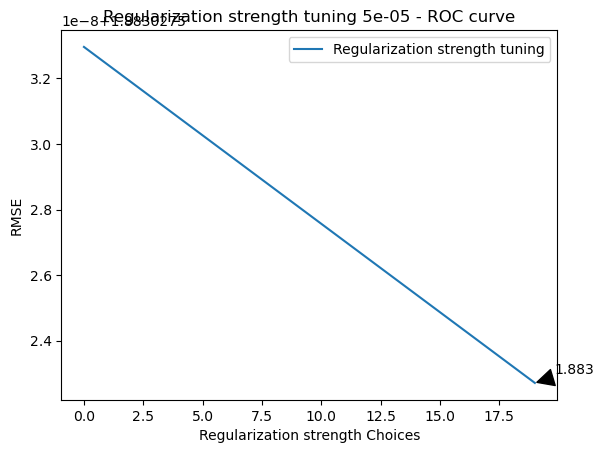

In [72]:
reg_list = list(np.linspace(1e-5,0.00005,20))
rmse_lst=[]

for i in reg_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        learning_rate="adaptive", 
                        alpha=i,
                        random_state=3612,
                        activation='identity',
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(reg_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(reg_list))), rmse_lst, label='Regularization strength tuning')
plt.xlabel('Regularization strength Choices')
plt.ylabel('RMSE')
plt.title(f"Regularization strength tuning {reg_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [73]:
index = np.argmin(rmse_lst)
best_reg_choice =  reg_list[index]
best_reg_choice

5e-05

## Activation function Choices

['identity', 'logistic', 'tanh', 'relu']


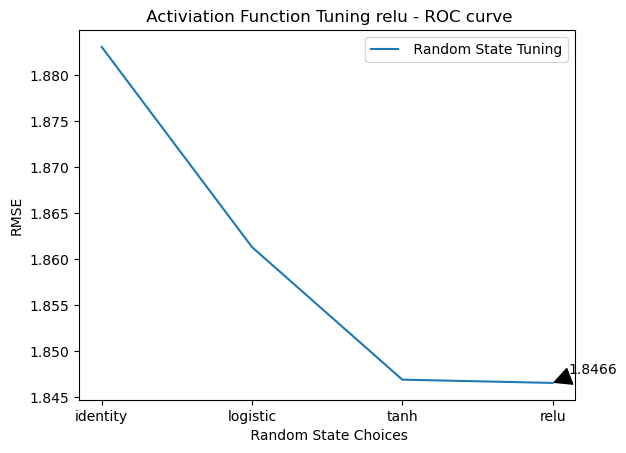

In [74]:
activation_list = ['identity','logistic','tanh','relu']
rmse_lst=[]

for i in activation_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        learning_rate="adaptive", 
                        alpha=best_reg_choice,
                        random_state=3612,
                        activation=i,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(activation_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(activation_list, rmse_lst, label=' Random State Tuning')
plt.xlabel(' Random State Choices')
plt.ylabel('RMSE')
plt.title(f" Activiation Function Tuning {activation_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [75]:
index = np.argmin(rmse_lst)
best_act_choice =  activation_list[index]
best_act_choice

'relu'

# Test

In [76]:
X = np.concatenate((X_train_norm,X_valid_norm),axis=0)
y = np.concatenate((y_train_t2_value,y_valid_t2_value),axis=0)

In [77]:
# Final model
reg1 = MLPRegressor(solver=best_solver,
                    hidden_layer_sizes=best_layernumber,
                    learning_rate_init=best_lr_choice,
                    learning_rate="adaptive", 
                    alpha=best_reg_choice,
                    activation=best_act_choice,
                    
                    max_iter=300,
                    power_t=0.5,
                    shuffle=True, 
                    random_state=3612, 
                    tol=0.001, 
                    verbose=False, 
                    warm_start=True, 
                    momentum=0.5, 
                    early_stopping=True, 
                    validation_fraction=0.1
                   )

reg1.fit(X,y)
y_pred = reg1.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

1.833525417847007

In [78]:
reg1

MLPRegressor(alpha=5e-05, early_stopping=True, hidden_layer_sizes=(3, 18),
             learning_rate='adaptive', learning_rate_init=0.01, max_iter=300,
             momentum=0.5, random_state=3612, solver='sgd', tol=0.001,
             warm_start=True)

In [79]:
X_test_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,...,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03
mean,-4.524333e-17,2.966776e-18,5.933551e-18,-2.373420e-17,-5.340196e-17,1.483388e-17,1.780065e-17,-1.223795e-17,8.900327e-18,2.299251e-17,...,-1.186710e-17,5.933551e-18,2.373420e-17,-1.780065e-17,-2.373420e-17,-4.746841e-17,-5.933551e-18,-1.186710e-17,-1.186710e-17,1.186710e-17
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,...,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00
min,-3.866192e-01,-4.765697e+00,-1.111802e+00,-2.611997e+00,-3.601494e-01,-1.258709e+00,-3.693002e+00,-6.436459e-01,-1.123647e+00,-3.586934e+00,...,-5.136424e+00,-6.571703e+00,-5.751612e+00,-8.085019e+00,-6.612951e+00,-7.322217e+00,-2.216855e+00,-6.238583e-01,-4.273184e+00,-1.726776e+00
25%,-2.866700e-01,-1.151935e-17,-2.726431e-01,-5.987448e-01,-2.799569e-01,-2.882546e-18,-5.606852e-01,-3.755694e-01,-5.882805e-01,-4.803815e-01,...,-1.194131e-01,-4.959732e-01,-7.394177e-01,-6.241685e-01,-9.967123e-02,-6.577652e-02,5.675102e-18,-2.881372e-17,-4.788060e-01,-5.546262e-01
50%,-8.367707e-17,-1.151935e-17,2.530916e-17,-8.252631e-02,-7.218124e-17,-2.882546e-18,5.652010e-02,-2.539832e-17,-3.124413e-01,1.193247e-17,...,0.000000e+00,1.251068e-02,-1.262557e-01,-2.566844e-04,0.000000e+00,-8.734293e-17,5.675102e-18,-2.881372e-17,-5.272928e-18,-1.472327e-01
75%,-8.367707e-17,-1.151935e-17,2.530916e-17,4.853141e-01,-7.218124e-17,-2.882546e-18,5.502843e-01,-2.539832e-17,1.980391e-01,4.264394e-01,...,0.000000e+00,5.209945e-01,6.327505e-01,6.282353e-01,0.000000e+00,-8.734293e-17,5.675102e-18,-2.881372e-17,1.888961e-01,3.316333e-01
max,2.644274e+01,5.992146e+00,2.777082e+01,6.731558e+00,3.018609e+01,2.404813e+01,6.845778e+00,1.768981e+01,1.040765e+01,3.438273e+01,...,7.764461e+00,7.616300e+00,4.374362e+00,4.471973e+00,5.200926e+00,5.871311e+00,2.524288e+01,1.864271e+01,8.326082e+00,2.344432e+01


In [80]:

result = reg1.predict(X_test_norm)
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test_realmean.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out1.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1

,Predicted
Id,
32_175413_295037,2.745843
33_176176_296681,2.406033
42_119203_210828,2.671098
44_181750_291554,2.519922
61_176332_252348,2.736982
...,...
99883_150755_276467,4.153133
99897_162913_266801,3.746317
99913_175989_292375,3.018767
